# Time processing for every ONNX nodes in a graph

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

In [3]:
%matplotlib inline

## LogisticRegression

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [5]:
import numpy
from mlprodict.onnx_conv import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
with open("logreg_time.onnx", "wb") as f:
    f.write(onx.SerializeToString())
# add -l 1 if nothing shows up
%onnxview onx

In [6]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.199603
1,1,Normalizer,Normalizer,0.000091
2,2,Cast,Cast,0.000014
3,3,ZipMap,ZipMap,0.000016


In [7]:
oinf.run({'X': X_test})['output_probability'][:5]

{0: array([8.38235830e-01, 1.21554664e-03, 6.97352537e-04, 7.93823160e-01,
        9.24825077e-01]),
 1: array([0.16162989, 0.39692812, 0.25688601, 0.20607722, 0.07516498]),
 2: array([1.34279470e-04, 6.01856333e-01, 7.42416637e-01, 9.96200831e-05,
        9.94208860e-06])}

## Measure time spent in each node


With parameter ``node_time=True``, method *run* returns the output and time measurement.

In [8]:
exe = oinf.run({'X': X_test}, node_time=True)
exe[1]

[{'i': 0,
  'name': 'LinearClassifier',
  'op_type': 'LinearClassifier',
  'time': 0.00015699999999974068},
 {'i': 1,
  'name': 'Normalizer',
  'op_type': 'Normalizer',
  'time': 5.43000000003957e-05},
 {'i': 2, 'name': 'Cast', 'op_type': 'Cast', 'time': 1.1699999999947863e-05},
 {'i': 3,
  'name': 'ZipMap',
  'op_type': 'ZipMap',
  'time': 1.940000000111297e-05}]

In [9]:
import pandas
pandas.DataFrame(exe[1])

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.000157
1,1,Normalizer,Normalizer,0.000054
2,2,Cast,Cast,0.000012
3,3,ZipMap,ZipMap,0.000019


## Logistic regression: python runtime vs onnxruntime

Function [enumerate_validated_operator_opsets](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=enumerate_validated_operator_opsets#mlprodict.onnxrt.validate.validate.enumerate_validated_operator_opsets) implements automated tests for every model with artificial data. Option ``node_time`` automatically returns the time spent in each node and does it multiple time.

In [10]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=12,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-cl"))

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [11]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,LinearClassifier,LinearClassifier,0.000018,1,0.000033,0.000015,20,30,0-LinearClassifier
1,1,Normalizer,Normalizer,0.000017,1,0.000069,0.000012,20,30,1-Normalizer
2,2,Cast,Cast,0.000004,1,0.000009,0.000003,20,30,2-Cast
3,3,ZipMap,ZipMap,0.000005,1,0.000007,0.000004,20,30,3-ZipMap
4,0,LinearClassifier,LinearClassifier,0.000020,10,0.000052,0.000017,20,20,0-LinearClassifier
5,1,Normalizer,Normalizer,0.000015,10,0.000035,0.000013,20,20,1-Normalizer
6,2,Cast,Cast,0.000004,10,0.000013,0.000003,20,20,2-Cast
7,3,ZipMap,ZipMap,0.000004,10,0.000008,0.000004,20,20,3-ZipMap
8,0,LinearClassifier,LinearClassifier,0.000024,100,0.000036,0.000019,10,8,0-LinearClassifier
9,1,Normalizer,Normalizer,0.000018,100,0.000023,0.000015,10,8,1-Normalizer


Following tables shows the time spent in each node, it is relative to the total time. For one observation, the runtime spends 10% of the time in ZipMap, it is only 1% or 2% with 10 observations. These proportions change due to the computing cost of each node.

In [12]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.410138,0.459103,0.450882,0.512622,0.530490,0.544785
1-Normalizer,0.390060,0.353622,0.350126,0.414227,0.456671,0.451642
2-Cast,0.095729,0.089857,0.074343,0.034398,0.006092,0.002306
3-ZipMap,0.104073,0.097418,0.124649,0.038753,0.006747,0.001267


The python implementation of *ZipMap* does not change the data but wraps in into a frozen class [ArrayZipMapDitionary](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_zipmap.py#L90) which mocks a list of dictionaries *pandas* can ingest to create a DataFrame. The cost is a fixed cost and does not depend on the number of processed rows.

In [13]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
print(profile(lambda: oinf.run({'X': bigX}), pyinst_format="text")[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 00:28:08  Samples:  4
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.009     CPU time: 0.031
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-287476aa-b8ba-4140-902a-b0aad833ffd0.json

0.008 profile  pyquickhelper\pycode\profiling.py:49
`- 0.008 <lambda>  <ipython-input-13-ccd42692a7ed>:3
   `- 0.008 run  mlprodict\onnxrt\onnx_inference.py:475
      `- 0.008 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:558
         `- 0.008 run  mlprodict\onnxrt\onnx_inference_node.py:141
            |- 0.005 run  mlprodict\onnxrt\ops_cpu\_op.py:417
            |  `- 0.005 run  mlprodict\onnxrt\ops_cpu\_op.py:298
            |     `- 0.005 _run  mlprodict\onnxrt\ops_cpu\op_linear_classifier.py:40
            |        |- 0.003 [self]  
            |        `- 0.002 argmax  <__array_function__ internals>:2
            |           `- 0

The class *ArrayZipMapDictionary* is fast to build but has an overhead after that because it builds data when needed.

In [14]:
res = oinf.run({'X': bigX})
prob = res['output_probability']
type(prob)

mlprodict.onnxrt.ops_cpu.op_zipmap.ArrayZipMapDictionary

In [15]:
%timeit pandas.DataFrame(prob)

721 ms ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
list_of_dict = [v.asdict() for v in prob]
%timeit pandas.DataFrame(list_of_dict)

108 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But if you just need to do the following:

In [17]:
%timeit pandas.DataFrame(prob).values

713 ms ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then, you can just do that:

In [18]:
print(prob.columns)
%timeit prob.values

[0, 1, 2]
390 ns ± 51.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And then:


In [19]:
%timeit -n 100 pandas.DataFrame(prob.values, columns=prob.columns)

215 µs ± 82.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can then compare to what *onnxruntime* would do when the runtime is called indenpently for each node. We use the runtime named [onnxruntime2](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/onnx_runtime.html?highlight=onnxruntime2#onnxruntime2-independent-onnxruntime-for-every-node). Class *OnnxInference* splits the ONNX graph into multiple ONNX graphs, one for each node, and then calls *onnxruntime* for each of them indenpently. *Python* handles the graph logic.

In [20]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=12,
            runtime='onnxruntime2', debug=False, node_time=True))

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_logistic.py:1356: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\xavierdupre\__home_\g

In [21]:
res0 = None
for i, r in enumerate(res):
    if "available-ERROR" in r:
        print(i, str(r['available-ERROR']).split("\n")[0])
    elif res0 is None:
        res0 = r

0 Unable to load node 'ZipMap' (output type was inferred)
1 Unable to load node 'ZipMap' (output type was inferred)
4 Unable to load node 'LinearClassifier' (output type was guessed)
5 Unable to load node 'LinearClassifier' (output type was guessed)
6 Unable to load node 'LinearClassifier' (output type was guessed)
7 Unable to load node 'LinearClassifier' (output type was guessed)
8 Unable to load node 'ZipMap' (output type was inferred)
9 Unable to load node 'ZipMap' (output type was inferred)


In [22]:
if '_6ort_run_batch_exc' in res[0]:
    m = "Something went wrong.", res[0]['_6ort_run_batch_exc']
else:
    df = pandas.DataFrame(res0['bench-batch'])
    print(df)
    df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
    piv = df.pivot('step', 'N', 'time')
    total = piv.sum(axis=0)
    m = piv / total
m

   i              name           op_type      time       N  max_time  \
0  0  LinearClassifier  LinearClassifier  0.000052       1  0.000190   
1  0  LinearClassifier  LinearClassifier  0.000044      10  0.000070   
2  0  LinearClassifier  LinearClassifier  0.000071     100  0.000133   
3  0  LinearClassifier  LinearClassifier  0.000066    1000  0.000079   
4  0  LinearClassifier  LinearClassifier  0.000409   10000  0.000408   
5  0  LinearClassifier  LinearClassifier  0.003275  100000  0.003275   

   min_time  repeat  number  
0  0.000028      20      30  
1  0.000031      20      20  
2  0.000046      10       8  
3  0.000057       5       5  
4  0.000365       3       3  
5  0.003275       1       2  


N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,1.0,1.0,1.0,1.0,1.0,1.0


*onnxruntime* creates a new container each time a ZipMap is executed. That's whay it takes that much time and the ratio increases when the number of observations increases.

## GaussianProcessRegressor

This operator is slow for small batches compare to scikit-learn but closes the gap as the batch size increases. Let’s see where the time goes.

In [23]:
from onnx.defs import onnx_opset_version
from mlprodict.tools.asv_options_helper import get_opset_number_from_onnx
onnx_opset_version(), get_opset_number_from_onnx()

(12, 12)

In [24]:
res = list(enumerate_validated_operator_opsets(
            verbose=1, models={"GaussianProcessRegressor"},
            opset_min=get_opset_number_from_onnx(),
            opset_max=get_opset_number_from_onnx(),
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

[enumerate_validated_operator_opsets] opset in [12, 12].


GaussianProcessRegressor    :   0%|          | 0/1 [00:00<?, ?it/s]

[enumerate_compatible_opset] opset in [12, 12].


GaussianProcessRegressor    : 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


In [25]:
res0 = None
for i, r in enumerate(res):
    if "available-ERROR" in r:
        print(i, str(r['available-ERROR']).split("\n")[0])
    elif res0 is None:
        res0 = r

In [26]:
df = pandas.DataFrame(res0['bench-batch'])
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
df.head()

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,kgpd_CDist,CDist,0.000033,1,0.000045,0.000027,20,30,00-kgpd_CDist
1,1,kgpd_Div,Div,0.000009,1,0.000016,0.000007,20,30,01-kgpd_Div
2,2,kgpd_Mul,Mul,0.000006,1,0.000007,0.000005,20,30,02-kgpd_Mul
3,3,kgpd_Sin,Sin,0.000007,1,0.000009,0.000006,20,30,03-kgpd_Sin
4,4,kgpd_Div1,Div,0.000007,1,0.000008,0.000005,20,30,04-kgpd_Div1


In [27]:
pivpy = df.pivot('step', 'N', 'time')
total = pivpy.sum(axis=0)
pivpy / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-kgpd_CDist,0.311496,0.300665,0.244035,0.227984,0.264447,0.288546
01-kgpd_Div,0.082535,0.067193,0.028348,0.011667,0.012230,0.015447
02-kgpd_Mul,0.059840,0.050664,0.018670,0.006959,0.010950,0.012468
03-kgpd_Sin,0.067037,0.086529,0.106165,0.113068,0.102102,0.107563
04-kgpd_Div1,0.061852,0.053088,0.025749,0.010935,0.009810,0.009875
05-kgpd_Pow,0.072520,0.166539,0.361318,0.438253,0.418169,0.404182
06-kgpd_Mul1,0.057508,0.050477,0.020386,0.010334,0.009079,0.010466
07-kgpd_Exp,0.067885,0.098850,0.150876,0.168079,0.165177,0.145106
08-gpr_MatMul,0.137546,0.064570,0.025069,0.009029,0.007134,0.006159


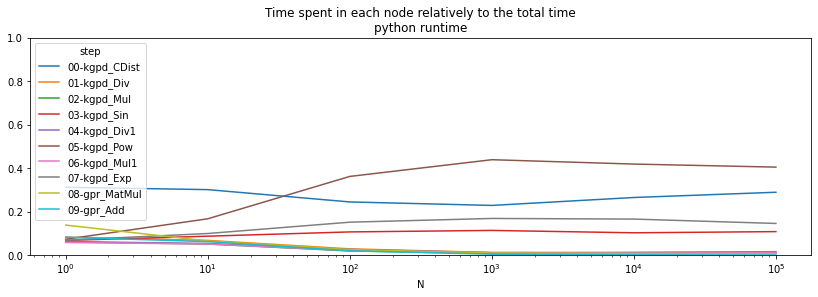

In [28]:
ax = (pivpy / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\npython runtime");

The operator *Scan* is clearly time consuming when the batch size is small. *onnxruntime* is more efficient for this one.

In [29]:
res = list(enumerate_validated_operator_opsets(
            verbose=1, models={"GaussianProcessRegressor"}, 
            opset_min=get_opset_number_from_onnx(),
            opset_max=get_opset_number_from_onnx(),
            runtime='onnxruntime2', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

[enumerate_validated_operator_opsets] opset in [12, 12].


GaussianProcessRegressor    :   0%|          | 0/1 [00:00<?, ?it/s]

[enumerate_compatible_opset] opset in [12, 12].


GaussianProcessRegressor    : 100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


In [30]:
try:
    df = pandas.DataFrame(res[0]['bench-batch'])
except KeyError as e:
    print("No model available.")
    r, df = None, None
if df is not None:
    df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
    pivort = df.pivot('step', 'N', 'time')
    total = pivort.sum(axis=0)
    r = pivort / total
r

N,1,10,100,1000,10000,100000
step,,,,,,
00-kgpd_CDist,0.114001,0.120884,0.128845,0.148042,0.156776,0.180377
01-kgpd_Div,0.101792,0.098622,0.085983,0.085108,0.086603,0.084520
02-kgpd_Mul,0.099980,0.097547,0.084001,0.064706,0.072849,0.081023
03-kgpd_Sin,0.089632,0.103505,0.194194,0.301002,0.245769,0.260717
04-kgpd_Div1,0.099119,0.096737,0.088709,0.063237,0.095840,0.091635
05-kgpd_Pow,0.108045,0.098307,0.081161,0.064898,0.079015,0.076962
06-kgpd_Mul1,0.098561,0.098475,0.082770,0.063557,0.087732,0.076762
07-kgpd_Exp,0.090019,0.087015,0.086282,0.088542,0.103798,0.087690
08-gpr_MatMul,0.100426,0.102766,0.106220,0.102751,0.069157,0.059617


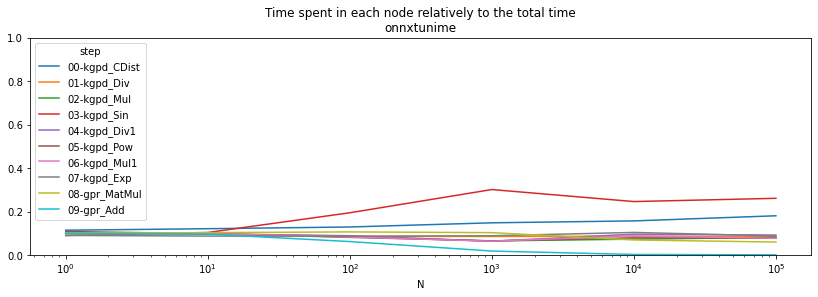

In [31]:
if r is not None:
    ax = (pivort / total).T.plot(logx=True, figsize=(14, 4))
    ax.set_ylim([0,1])
    ax.set_title("Time spent in each node relatively to the total time\nonnxtunime");

The results are relative. Let's see which runtime is best node by node.

In [32]:
if r is not None:
    r = (pivort - pivpy) / pivpy
r

N,1,10,100,1000,10000,100000
step,,,,,,
00-kgpd_CDist,-0.239113,-0.367743,-0.630420,-0.703226,-0.677041,-0.631775
01-kgpd_Div,1.564119,1.308106,1.123155,2.333824,2.857590,2.223117
02-kgpd_Mul,2.473648,2.027773,2.149388,3.249448,2.624165,2.828025
03-kgpd_Sin,1.779780,0.881090,0.280401,0.216680,0.311288,0.427768
04-kgpd_Div1,2.331710,1.865534,1.411570,1.642922,4.321977,4.466249
05-kgpd_Pow,2.097502,-0.071724,-0.842765,-0.932321,-0.897065,-0.887837
06-kgpd_Mul1,2.563218,2.067909,1.842112,1.811019,4.263897,3.320524
07-kgpd_Exp,1.756911,0.384288,-0.599693,-0.759241,-0.657668,-0.644029
08-gpr_MatMul,0.517953,1.502798,1.965953,4.201281,4.281286,4.701255


Based on this, *onnxruntime* is faster for operators *Scan*, *Pow*, *Exp* and slower for all the others.

## Measuring the time with a custom dataset

We use the example [Comparison of kernel ridge and Gaussian process regression](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py).

In [33]:
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = numpy.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = numpy.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=5))

In [34]:
onx = to_onnx(gpr, X_test.astype(numpy.float64))
with open("gpr_time.onnx", "wb") as f:
    f.write(onx.SerializeToString())
%onnxview onx -r 1

In [35]:
from mlprodict.tools import get_ir_version_from_onnx
onx.ir_version = get_ir_version_from_onnx()

In [36]:
oinfpy = OnnxInference(onx, runtime="python")
oinfort = OnnxInference(onx, runtime="onnxruntime2")

``runtime==onnxruntime2`` tells the class ``OnnxInference`` to use *onnxruntime* for every node independently, there are as many calls as there are nodes in the graph.

In [37]:
respy = oinfpy.run({'X': X_test}, node_time=True)
try:
    resort = oinfort.run({'X': X_test}, node_time=True)
except Exception as e:
    print(e)
    resort = None

In [38]:
if resort is not None:
    df = pandas.DataFrame(respy[1]).merge(pandas.DataFrame(resort[1]), on=["i", "name", "op_type"],
                                        suffixes=("_py", "_ort"))
    df['delta'] = df.time_ort - df.time_py
else:
    df = None
df

,i,name,op_type,time_py,time_ort,delta
0,0,Sc_Scan,Scan,0.007998,0.005970,-0.002028
1,1,kgpd_Transpose,Transpose,0.000032,0.000599,0.000567
2,2,kgpd_Sqrt,Sqrt,0.000063,0.000112,0.000049
3,3,kgpd_Div,Div,0.000143,0.000097,-0.000045
4,4,kgpd_Mul,Mul,0.000038,0.000321,0.000283
5,5,kgpd_Sin,Sin,0.000095,0.000146,0.000051
6,6,kgpd_Div1,Div,0.000027,0.000096,0.000069
7,7,kgpd_Pow,Pow,0.000299,0.000104,-0.000196
8,8,kgpd_Mul1,Mul,0.000032,0.000097,0.000065
9,9,kgpd_Exp,Exp,0.000383,0.000111,-0.000271


The following function runs multiple the same inference and aggregates the results node by node.

In [39]:
from mlprodict.onnxrt.validate.validate import benchmark_fct
res = benchmark_fct(lambda X: oinfpy.run({'X': X_test}, node_time=True), 
                    X_test, node_time=True)

In [40]:
df = pandas.DataFrame(res)
df[df.N == 100]

,i,name,op_type,time,N,max_time,min_time,repeat,number
24,0,Sc_Scan,Scan,0.004154,100,0.004330,0.003843,10,8
25,1,kgpd_Transpose,Transpose,0.000013,100,0.000019,0.000010,10,8
26,2,kgpd_Sqrt,Sqrt,0.000018,100,0.000022,0.000015,10,8
27,3,kgpd_Div,Div,0.000025,100,0.000092,0.000015,10,8
28,4,kgpd_Mul,Mul,0.000012,100,0.000019,0.000009,10,8
29,5,kgpd_Sin,Sin,0.000057,100,0.000070,0.000050,10,8
30,6,kgpd_Div1,Div,0.000014,100,0.000017,0.000011,10,8
31,7,kgpd_Pow,Pow,0.000172,100,0.000198,0.000155,10,8
32,8,kgpd_Mul1,Mul,0.000020,100,0.000101,0.000009,10,8
33,9,kgpd_Exp,Exp,0.000213,100,0.000249,0.000193,10,8


In [41]:
df100 = df[df.N == 100]

In [42]:
%matplotlib inline

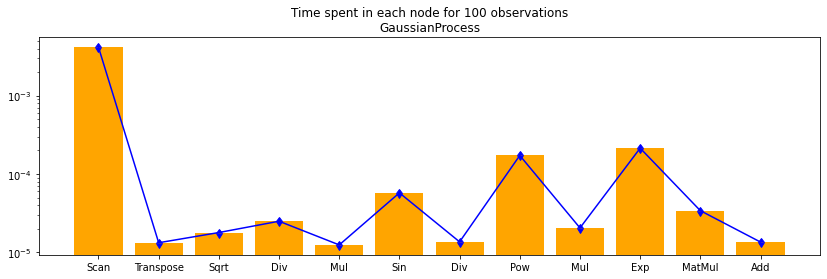

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100.time, align='center', color='orange')
ax.set_xticks(df100.i)
ax.set_yscale('log')
ax.set_xticklabels(df100.op_type)
ax.errorbar(df100.i, df100.time, 
            numpy.abs(df100[["min_time", "max_time"]].T.values - df100.time.values.ravel()),
            uplims=True, lolims=True, color='blue')
ax.set_title("Time spent in each node for 100 observations\nGaussianProcess");

In [44]:
df100c = df100.cumsum()

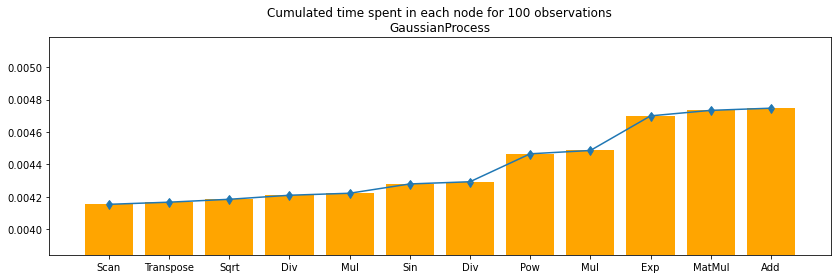

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100c.time, align='center', color='orange')
ax.set_xticks(df100.i)
#ax.set_yscale('log')
ax.set_ylim([df100c.min_time.min(), df100c.max_time.max()])
ax.set_xticklabels(df100.op_type)
ax.errorbar(df100.i, df100c.time, 
            numpy.abs((df100c[["min_time", "max_time"]].T.values - df100c.time.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess");

## onnxruntime2 / onnxruntime1

The runtime ``onnxruntime1`` uses *onnxruntime* for the whole ONNX graph. There is no way to get the computation time for each node except if we create a ONNX graph for each intermediate node.

In [46]:
oinfort1 = OnnxInference(onx, runtime='onnxruntime1')

In [47]:
split = oinfort1.build_intermediate()
split

OrderedDict([('scan0', OnnxInference(...)),
             ('scan1', OnnxInference(...)),
             ('kgpd_transposed0', OnnxInference(...)),
             ('kgpd_Y0', OnnxInference(...)),
             ('kgpd_C03', OnnxInference(...)),
             ('kgpd_C02', OnnxInference(...)),
             ('kgpd_output02', OnnxInference(...)),
             ('kgpd_C01', OnnxInference(...)),
             ('kgpd_Z0', OnnxInference(...)),
             ('kgpd_C0', OnnxInference(...)),
             ('kgpd_output01', OnnxInference(...)),
             ('gpr_Y0', OnnxInference(...)),
             ('GPmean', OnnxInference(...))])

In [48]:
dfs = []
for k, v in split.items():
    print("node", k)
    res = benchmark_fct(lambda x: v.run({'X': x}), X_test)
    df = pandas.DataFrame(res)
    df['name'] = k
    dfs.append(df.reset_index(drop=False))

node scan0
node scan1
node kgpd_transposed0
node kgpd_Y0
node kgpd_C03
node kgpd_C02
node kgpd_output02
node kgpd_C01
node kgpd_Z0
node kgpd_C0
node kgpd_output01
node gpr_Y0
node GPmean


In [49]:
df = pandas.concat(dfs)
df.head()

,index,1,10,100,1000,10000,100000,name
0,average,0.000623,0.000592,0.000754,0.002202,0.017529,0.201192,scan0
1,deviation,0.000115,0.000030,0.000034,0.000026,0.000976,0.000000,scan0
2,min_exec,0.000541,0.000537,0.000657,0.002169,0.016677,0.201192,scan0
3,max_exec,0.000980,0.000639,0.000780,0.002239,0.018896,0.201192,scan0
4,repeat,20.000000,20.000000,10.000000,5.000000,3.000000,1.000000,scan0


In [50]:
df100c = df[df['index'] == "average"]
df100c_min = df[df['index'] == "min_exec"]
df100c_max = df[df['index'] == "max_exec"]
ave = df100c.iloc[:, 4]
ave_min = df100c_min.iloc[:, 4]
ave_max = df100c_max.iloc[:, 4]
ave.shape, ave_min.shape, ave_max.shape
index = numpy.arange(ave.shape[0])

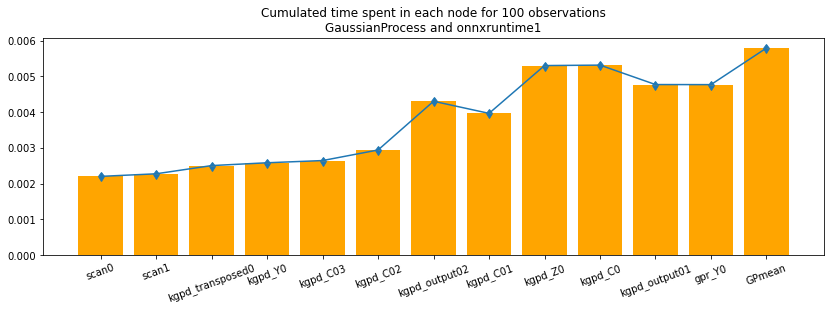

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(index, ave, align='center', color='orange')
ax.set_xticks(index)
ax.set_xticklabels(df100c.name)
for tick in ax.get_xticklabels():
    tick.set_rotation(20)
ax.errorbar(index, ave, 
            numpy.abs((numpy.vstack([ave_min.values, ave_max.values]) - ave.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 "
             "observations\nGaussianProcess and onnxruntime1");

The visual graph helps matching the output names with the operator type. The curve is not monotononic because each experiment computes every output from the start. The number of repetitions should be increased. Documentation of function [benchmark_fct](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=benchmark_fct#mlprodict.onnxrt.validate.validate.benchmark_fct) tells how to do it.